In [4]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from IPython.display import display_html
from itertools import chain, cycle
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings('ignore')

### Project Setup

In [59]:
columns=['Customer Number', 'Offer Accepted', 'Reward', 'Mailer Type', 'Income Level','Bank Accounts Open', \
         'Overdraft Protection', 'Credit Rating','Credit Cards Held', 'Homes Owned', 'Household Size', \
         'Own Your Home', 'Average Balance', 'Q1 Balance', 'Q2 Balance',  'Q3 Balance', 'Q4 Balance']

In [60]:
df_init = pd.read_csv('./files/creditcardmarketing.csv', names=columns)
df_init.head(3)

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,Bank Accounts Open,Overdraft Protection,Credit Rating,Credit Cards Held,Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


In [61]:
# custom class for initial data cleaning
class CustomInitialDataCleaner:
    def __init__(self):
        pass
    
    def __remove_duplicates(self, X):
        return X[~X.duplicated()]
    
    def __standardize_feature_headers(self, X):
        X.columns = [col.lower().replace(' ', '_') for col in X.columns]
        return X
        
    def clean(self, X):
        X = self.__remove_duplicates(X)
        return self.__standardize_feature_headers(X)

In [62]:
cleaner = CustomInitialDataCleaner()
df = cleaner.clean(df_init)
df.set_index('customer_number', inplace=True)
df.head(3)

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


In [63]:
df_nans = df[df.isna().any(axis=1)]
yes = df_nans[df_nans['offer_accepted'] == 'Yes'].shape
no = df_nans[df_nans['offer_accepted'] == 'No'].shape

print(f'total rows with nan values: {df_nans.shape[0]}')
print(f'from nan rows, how many with offer accepted YES: ', yes[0])
print(f'from nan rows, how many with offer accepted NO: ', no[0])

total rows with nan values: 24
from nan rows, how many with offer accepted YES:  2
from nan rows, how many with offer accepted NO:  22


- since nan values in very few rows - drop the nans completely

In [64]:
df.dropna(inplace=True)
df.isna().sum()

offer_accepted          0
reward                  0
mailer_type             0
income_level            0
bank_accounts_open      0
overdraft_protection    0
credit_rating           0
credit_cards_held       0
homes_owned             0
household_size          0
own_your_home           0
average_balance         0
q1_balance              0
q2_balance              0
q3_balance              0
q4_balance              0
dtype: int64

## EDA

Check numerical features

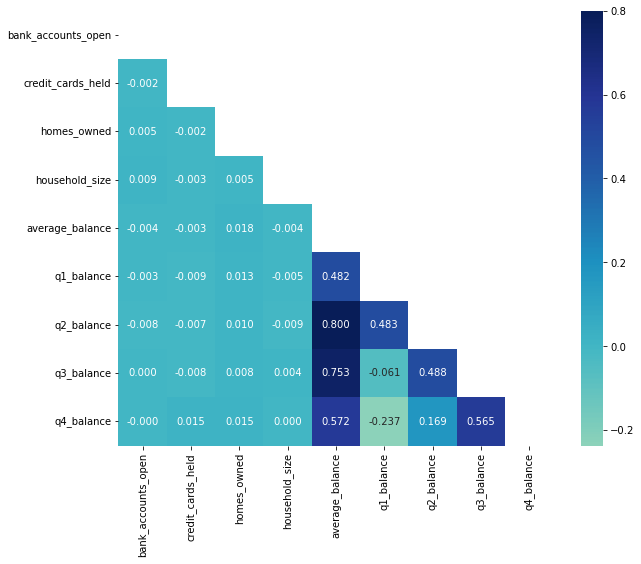

In [65]:
# correlation matrix:
num_corr = df.select_dtypes('number').corr()
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(num_corr, center=0, fmt=".3f", square=True, annot=True, mask=mask, cmap="YlGnBu")
plt.show()

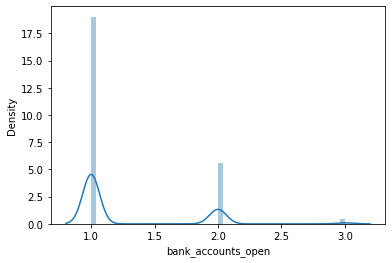

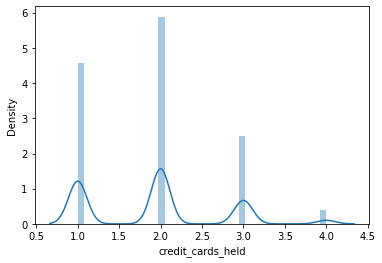

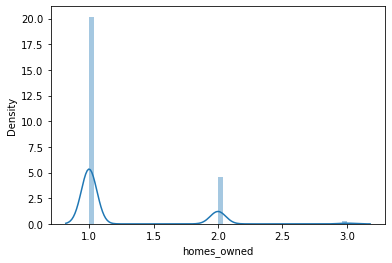

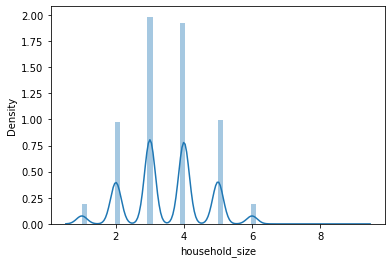

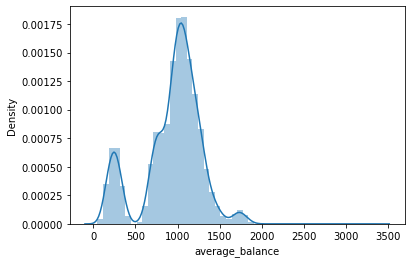

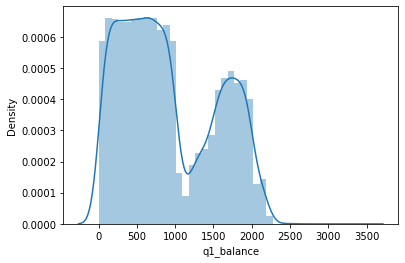

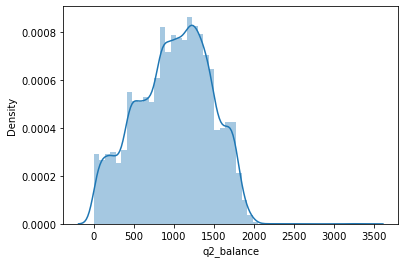

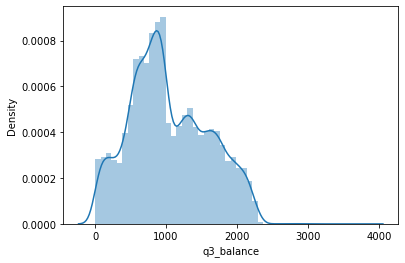

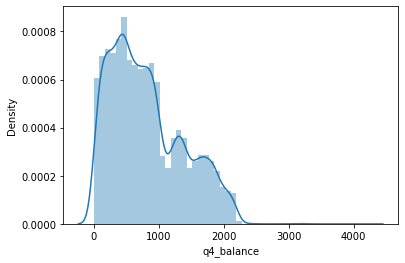

In [66]:
%matplotlib inline

for col in df.select_dtypes('number'):
    sns.distplot(df[col])
    plt.show()

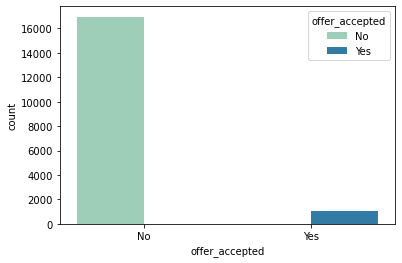

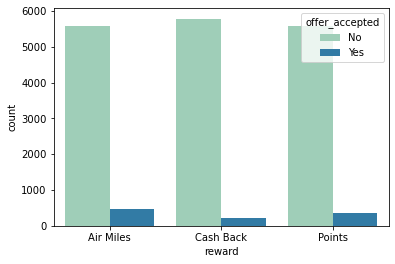

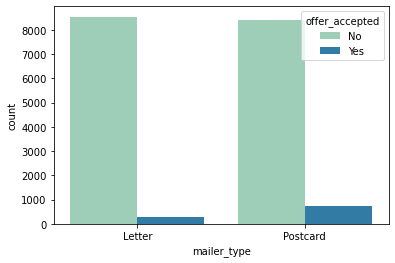

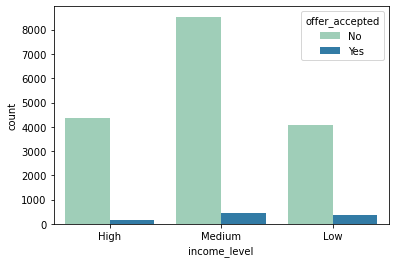

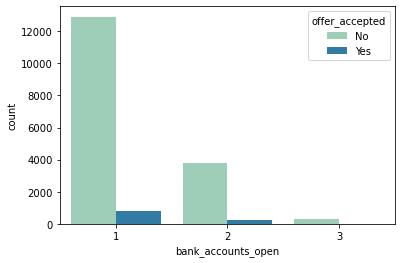

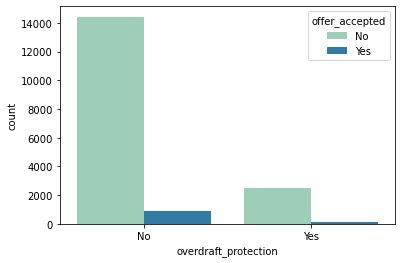

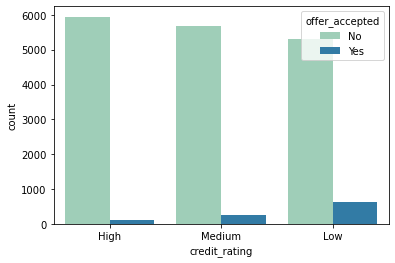

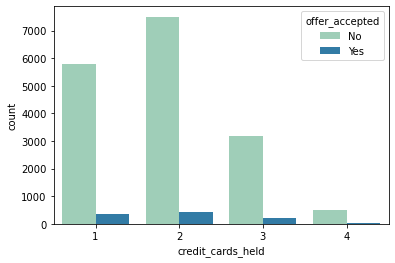

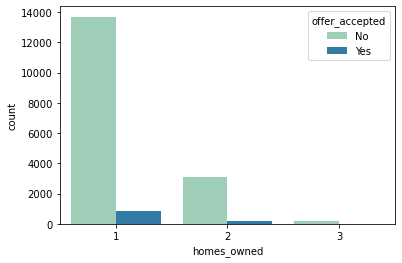

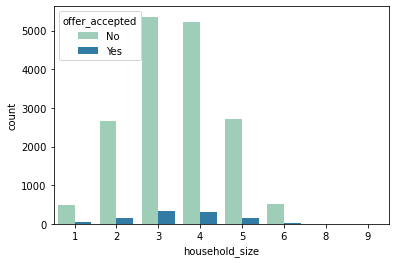

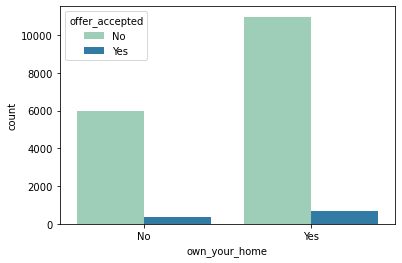

In [67]:
df_adjusted = df.loc[:, ~df.columns.isin(['q1_balance', 'q2_balance', 'q3_balance', 'q4_balance','average_balance'])]

for col in df_adjusted:
    sns.countplot(col, hue='offer_accepted', data=df, palette='YlGnBu')
    plt.show()

In [68]:
df.select_dtypes('object').apply(lambda col: col.unique())

offer_accepted                               [No, Yes]
reward                  [Air Miles, Cash Back, Points]
mailer_type                         [Letter, Postcard]
income_level                       [High, Medium, Low]
overdraft_protection                         [No, Yes]
credit_rating                      [High, Medium, Low]
own_your_home                                [No, Yes]
dtype: object

In [69]:
# Checking frequency of data
# There is some imbalance
for col in df.select_dtypes('object').columns:
    print(df[col].value_counts())
    print()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64

Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64

Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64

No     15300
Yes     2676
Name: overdraft_protection, dtype: int64

High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64

Yes    11636
No      6340
Name: own_your_home, dtype: int64



In [70]:
df['offer_accepted'].value_counts() / df.shape[0] * 100

No     94.320205
Yes     5.679795
Name: offer_accepted, dtype: float64

In [71]:
# Setting up crosstabs
reward = pd.crosstab(df['reward'], df['offer_accepted'], margins=True)
mailer_type = pd.crosstab(df['mailer_type'], df['offer_accepted'], margins=True)
income_level = pd.crosstab(df['income_level'], df['offer_accepted'], margins=True)
overdraft_protection = pd.crosstab(df['overdraft_protection'], df['offer_accepted'], margins=True)
credit_rating = pd.crosstab(df['credit_rating'], df['offer_accepted'], margins=True)
own_your_home = pd.crosstab(df['own_your_home'], df['offer_accepted'], margins=True)

all_crosstabs = [reward, mailer_type, income_level, overdraft_protection, credit_rating, own_your_home]

In [72]:
for tab in all_crosstabs:
    stat, p, dof, expected = chi2_contingency(tab)
    alpha = 0.05
    if p > alpha:
        print(p)
        print('Variables are independent')
        print()
    else:
        print(p)
        print('Variables are dependent')
        print()

1.4456214412928917e-19
Variables are dependent

1.1105174773164281e-35
Variables are dependent

3.559085897825231e-22
Variables are dependent

0.9979597462857913
Variables are independent

5.6707215130901575e-93
Variables are dependent

0.9999999997513797
Variables are independent



### Check for outliers

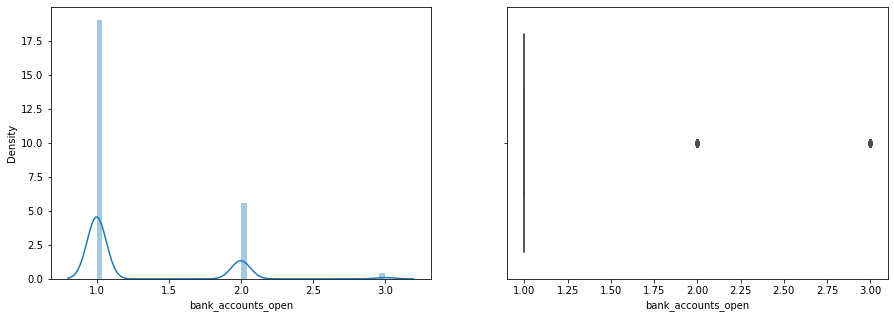

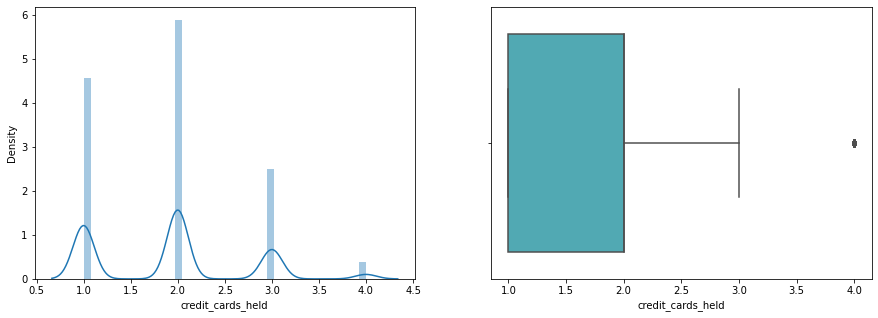

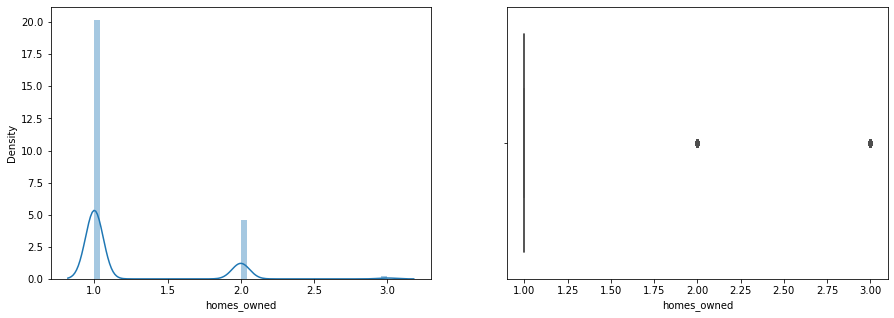

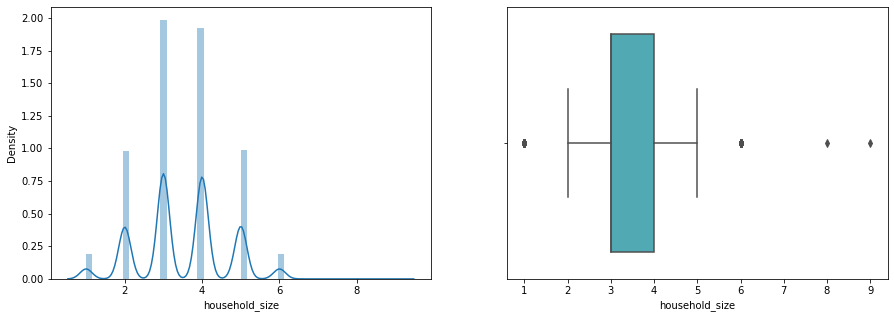

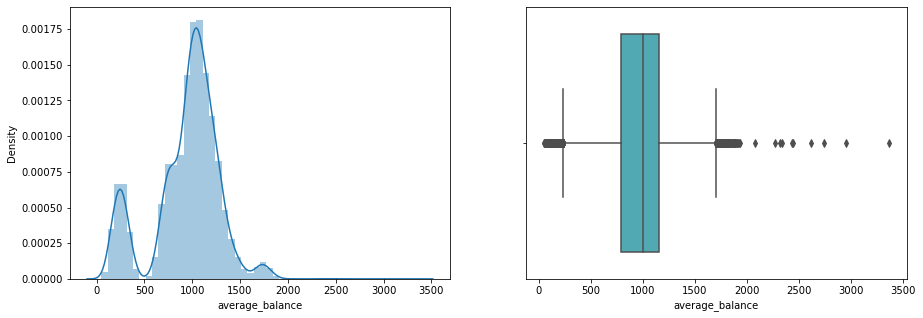

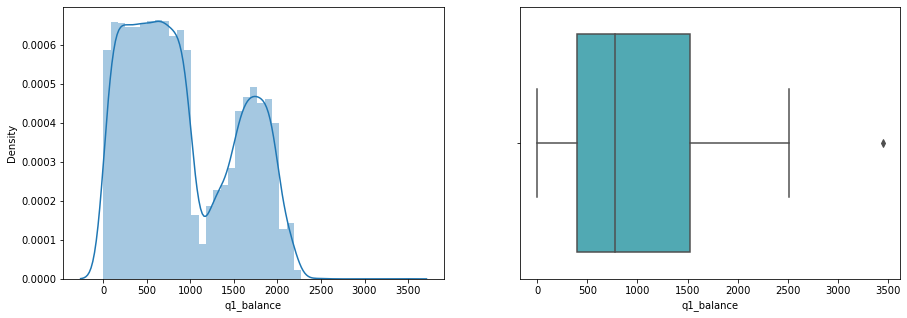

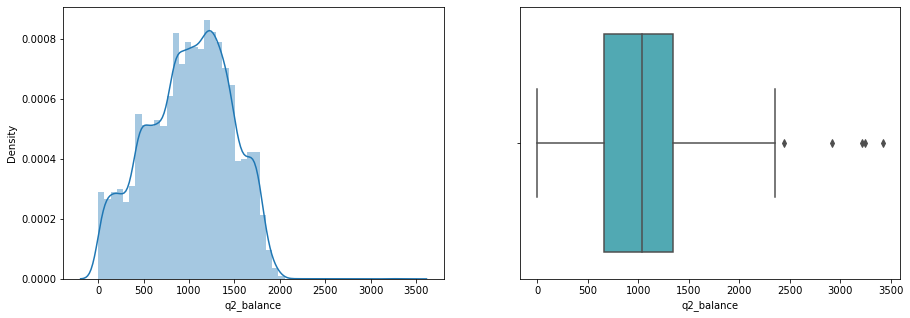

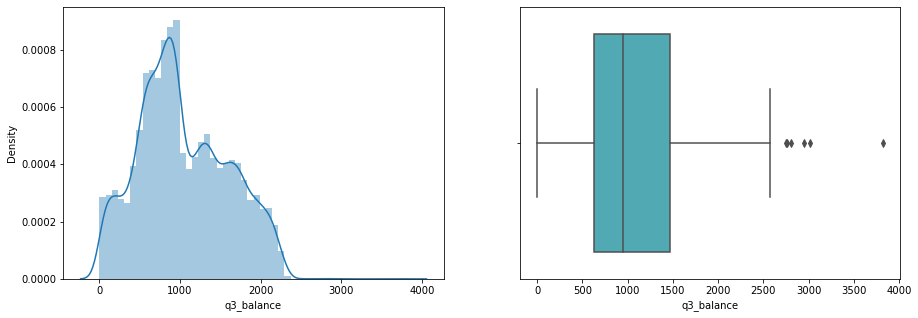

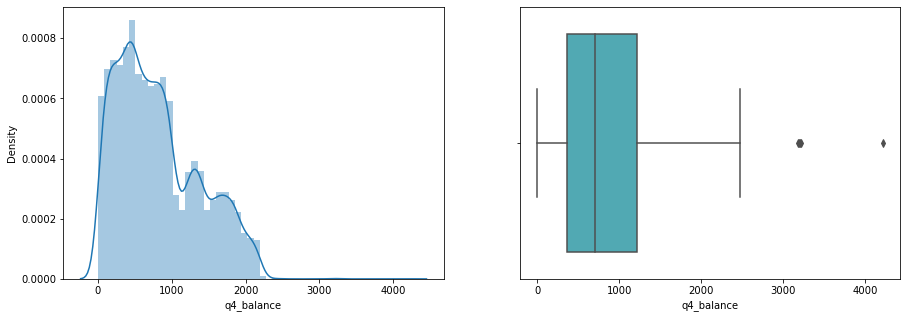

In [73]:
for col in df.select_dtypes('number'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.distplot(df[col], ax=ax[0])

    sns.boxplot(x=df[col], data=df, palette='YlGnBu', ax=ax[1])
    plt.show()
    

In [103]:
# Custom class to deal with outliers
# detects outliers and replaces them with mean value of the respecive feature

class CustomOutlierRemover:
    def __init__(self, outlier_threshold, skip_features=[], ):
        self.outlier_threshold = outlier_threshold
        self.skip_features = skip_features
        
    def __outliers_detect(self, X):
        for column in X.select_dtypes(np.number).columns:
            if column not in self.skip_features:
                upper = np.nanpercentile(X[column],75)
                lower = np.nanpercentile(X[column],25)
                iqr = upper - lower
                upper_limit = upper + self.outlier_threshold * iqr
                lower_limit = lower - self.outlier_threshold * iqr if \
                (lower - self.outlier_threshold * iqr) > 0 else 0
                filtered = X[(X[column]>lower_limit) & (X[column]<upper_limit)]
                if filtered.shape[0] != X.shape[0]:
                    self.detected_outliers_.append({
                        'column': column, 
                        'ul_ll': [upper_limit, lower_limit], 
                        'detected_elements': X.shape[0] - filtered.shape[0] 
                    })
                    self.count_total_outliers_ += X.shape[0] - filtered.shape[0]
        
    def __outliers_remove(self, X):
        for outlier in self.detected_outliers_:
            filter_max = X[outlier['column']] > outlier['ul_ll'][0]
            filter_min = X[outlier['column']] < outlier['ul_ll'][1]
            X[outlier['column']].loc[filter_min | filter_max] = X[outlier['column']].mean()
        return X
    
    def clean(self, X):
        X_c = X.copy()
        self.detected_outliers_ = []
        self.count_total_outliers_ = 0
        self.__outliers_detect(X_c)
        X_new = self.__outliers_remove(X_c)
        return X_new

In [111]:
skip_features = ['household_size', 'bank_accounts_open', 'credit_cards_held', 'homes_owned']
cor = CustomOutlierRemover(outlier_threshold=1.7, skip_features=skip_features)
df_ = cor.clean(df)

In [112]:
cor.detected_outliers_

[{'column': 'average_balance',
  'ul_ll': [1775.025, 165.72500000000002],
  'detected_elements': 464},
 {'column': 'q1_balance',
  'ul_ll': [3439.0249999999996, 0],
  'detected_elements': 6},
 {'column': 'q2_balance', 'ul_ll': [2496.3, 0], 'detected_elements': 5},
 {'column': 'q3_balance', 'ul_ll': [2874.0, 0], 'detected_elements': 4},
 {'column': 'q4_balance', 'ul_ll': [2655.3, 0], 'detected_elements': 10}]

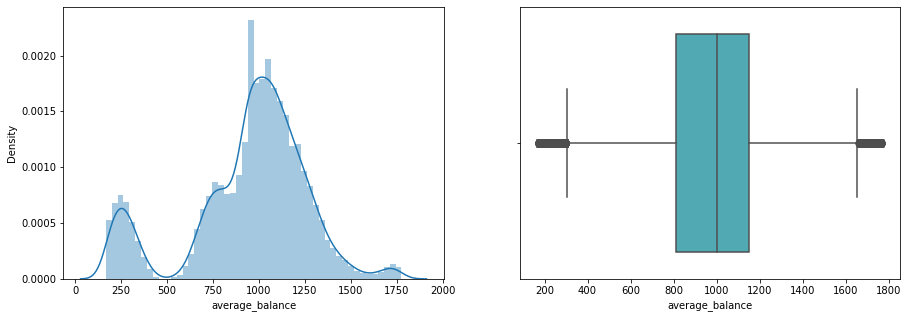

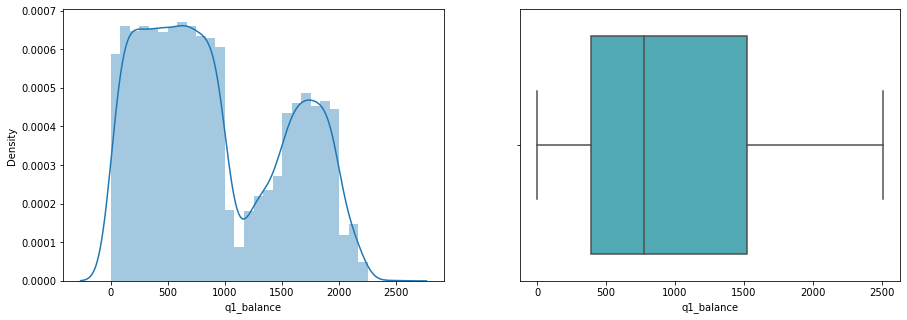

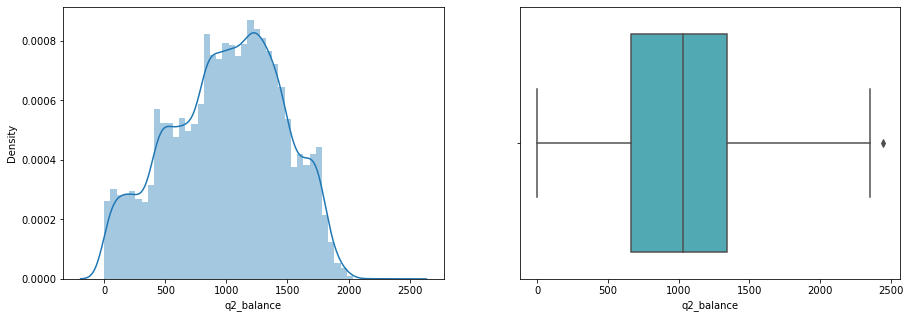

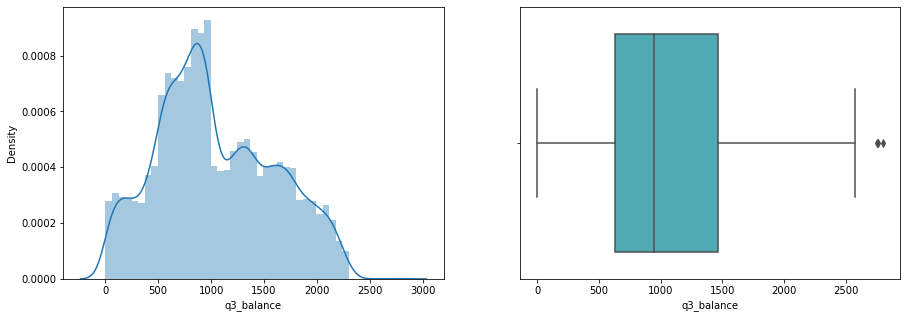

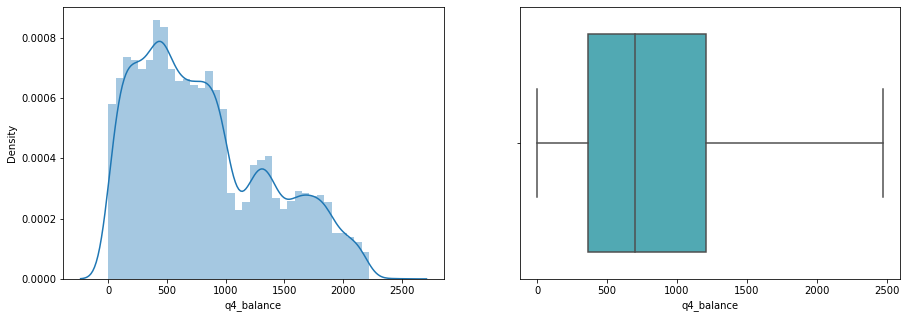

In [113]:
for item in cor.detected_outliers_:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.distplot(df_[item['column']], ax=ax[0])

    sns.boxplot(x=df_[item['column']], data=df_, palette='YlGnBu', ax=ax[1])
    plt.show()

In [159]:
cor.detected_outliers_

[{'column': 'average_balance',
  'ul_ll': [1775.025, 165.72500000000002],
  'removed_elements': 464},
 {'column': 'q1_balance',
  'ul_ll': [3439.0249999999996, -1525.2749999999999],
  'removed_elements': 1},
 {'column': 'q2_balance',
  'ul_ll': [2496.3, -491.29999999999995],
  'removed_elements': 4},
 {'column': 'q3_balance', 'ul_ll': [2874.0, -778.0], 'removed_elements': 3},
 {'column': 'q4_balance', 'ul_ll': [2655.3, -1080.3], 'removed_elements': 5}]

## Data Preprocessing

In [31]:
# split data before any tranformations
X = df.drop('offer_accepted', axis=1, inplace=False)
y = df['offer_accepted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [32]:
numerical = df.select_dtypes('number')
categorical = df.select_dtypes('object').drop('offer_accepted', axis=1, inplace=False)
cat_ordinal_features = categorical[['income_level', 'credit_rating']].columns
cat_onehot_features = categorical.loc[:, ~categorical.columns.isin(cat_ordinal_features)].columns


# custom function to create pipelines with flexible scaler, sampler (to balance classes), and model
# allows for quick pipeline composition to experiment with different setups
def make_custom_pipeline(scaler, sampler, model):
    custom_pipeline = Pipeline([
        ('scaling', ColumnTransformer([
            ('numerical', scaler, numerical.columns),
            ('cat_onehot', OneHotEncoder(sparse=False), cat_onehot_features),
            ('cat_ordinal', OrdinalEncoder(categories=[['Low', 'Medium', 'High'], \
                                                       ['Low', 'Medium', 'High']]), cat_ordinal_features),])),
        ('sampling', sampler),
        ('model', model)])
    
    return custom_pipeline

## Evaluate different models

In [33]:
# collection of utility functions for model evaluation


# function to display dataframes side by side
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    
# function to handle model results
def handle_classification_results(y_train, y_train_pred, y_test, y_test_pred, sampler, estimator, df_results):
    scores_train = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True)).T
    scores_test = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).T
    
    display_classification_results(scores_train, scores_test, [[y_train_pred, y_train, 'CM for Traning Data'], \
                                   [y_test_pred, y_test, 'CM for Test Data']], sampler, estimator)
    
    add_scores_to_overall_results(df_results, scores_test, sampler, estimator)


# function to print relevant information from predictions
def display_classification_results(scores_train, scores_test, target_data, sampler, estimator):
    class_weight = estimator.get_params().get('class_weight')
    print('='*100)
    print(f'{get_class_name(sampler)} {get_class_name(estimator)} class weight: {class_weight}')

    display_side_by_side(scores_train, scores_test, titles=['Train','Test'])

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i in range(2):
        cm = confusion_matrix(target_data[i][1], target_data[i][0], labels=estimator.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
        disp.plot(colorbar=False, ax=ax[i])
        disp.ax_.set_title(target_data[i][2])
    plt.show()
    
# function to add model scores to an overall overview of model performance for comparisson
def add_scores_to_overall_results(df_results, scores_test, sampler, estimator):
    df_results.loc[df_results.shape[0]] = [get_class_name(estimator), get_class_name(sampler),
                                           estimator.get_params().get('class_weight'), 
                                           scores_test.at["accuracy","f1-score"], scores_test.at["Yes","f1-score"],
                                          scores_test.at["Yes","precision"], scores_test.at["Yes","recall"],
                                          scores_test.at["No","f1-score"], scores_test.at["No","precision"],
                                          scores_test.at["No","recall"]]
    
def get_class_name(cl):
    return cl.__class__.__name__

### Apply Logistic Regression, KNN, Decision Tree Classifier and RandomForestClassifier

In [43]:
# df for overall results
model_comparisson = pd.DataFrame([], columns=['model', 'sampler', 'class_weight', 'f1_score', 'yes_f1', \
                                          'yes_precision', 'yes_recall', 'no_f1', 'no_precision', 'no_recall'])

SMOTE LogisticRegression class weight: None


,precision,recall,f1-score,support
No,0.973433,0.691587,0.808656,13563.000000
Yes,0.118255,0.686659,0.201762,817.000000
accuracy,0.691307,0.691307,0.691307,0.691307
macro avg,0.545844,0.689123,0.505209,14380.000000
weighted avg,0.924846,0.691307,0.774175,14380.000000
,precision,recall,f1-score,support
No,0.973630,0.696639,0.812167,3392.000000
Yes,0.119760,0.686275,0.203933,204.000000
accuracy,0.696051,0.696051,0.696051,0.696051
macro avg,0.546695,0.691457,0.508050,3596.000000


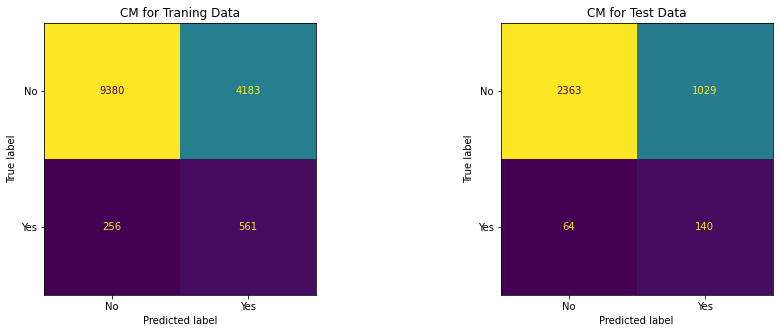

SMOTE LogisticRegression class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,0.986128,0.466490,0.633365,13563.000000
Yes,0.091411,0.891065,0.165813,817.000000
accuracy,0.490612,0.490612,0.490612,0.490612
macro avg,0.538770,0.678777,0.399589,14380.000000
weighted avg,0.935295,0.490612,0.606801,14380.000000
,precision,recall,f1-score,support
No,0.987813,0.454009,0.622097,3392.0000
Yes,0.090820,0.906863,0.165105,204.0000
accuracy,0.479700,0.479700,0.479700,0.4797
macro avg,0.539316,0.680436,0.393601,3596.0000


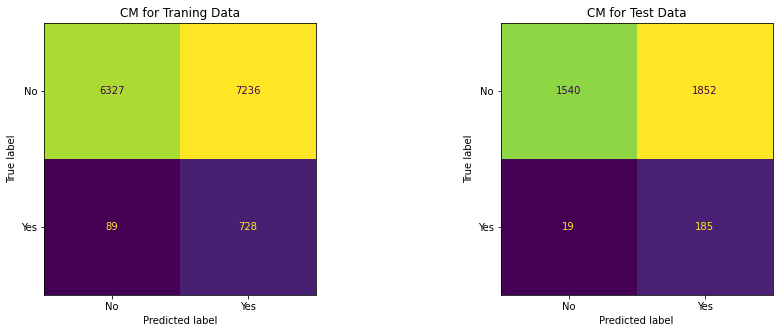

SMOTE KNeighborsClassifier class weight: None


,precision,recall,f1-score,support
No,1.000000,0.905552,0.950435,13563.000000
Yes,0.389418,1.000000,0.560549,817.000000
accuracy,0.910918,0.910918,0.910918,0.910918
macro avg,0.694709,0.952776,0.755492,14380.000000
weighted avg,0.965310,0.910918,0.928284,14380.000000
,precision,recall,f1-score,support
No,0.950444,0.819870,0.880342,3392.000000
Yes,0.088060,0.289216,0.135011,204.000000
accuracy,0.789766,0.789766,0.789766,0.789766
macro avg,0.519252,0.554543,0.507677,3596.000000


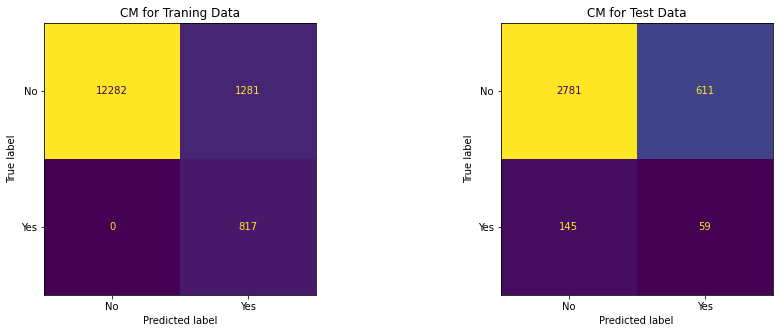

SMOTE DecisionTreeClassifier class weight: None


,precision,recall,f1-score,support
No,1.0,1.0,1.0,13563.0
Yes,1.0,1.0,1.0,817.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,14380.0
weighted avg,1.0,1.0,1.0,14380.0
,precision,recall,f1-score,support
No,0.944261,0.928950,0.936543,3392.000000
Yes,0.069498,0.088235,0.077754,204.000000
accuracy,0.881257,0.881257,0.881257,0.881257
macro avg,0.506880,0.508593,0.507149,3596.000000


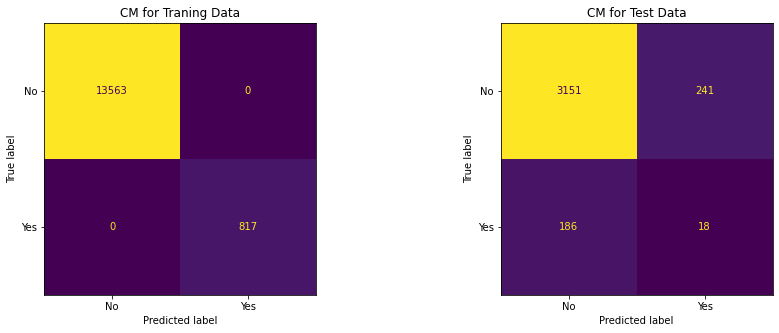

SMOTE DecisionTreeClassifier class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,1.0,1.0,1.0,13563.0
Yes,1.0,1.0,1.0,817.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,14380.0
weighted avg,1.0,1.0,1.0,14380.0
,precision,recall,f1-score,support
No,0.946365,0.936321,0.941316,3392.000000
Yes,0.100000,0.117647,0.108108,204.000000
accuracy,0.889878,0.889878,0.889878,0.889878
macro avg,0.523182,0.526984,0.524712,3596.000000


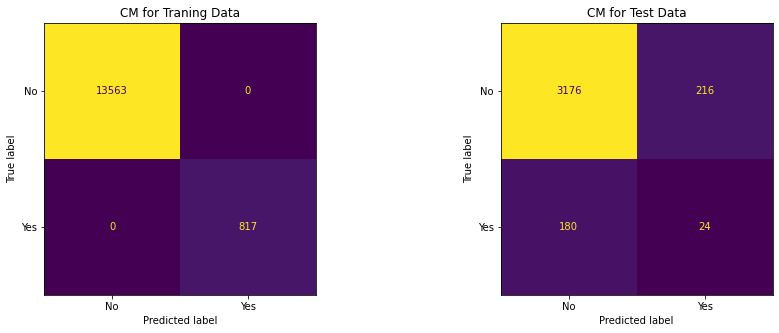

SMOTE RandomForestClassifier class weight: None


,precision,recall,f1-score,support
No,0.963397,0.842218,0.898741,13563.000000
Yes,0.151803,0.468788,0.229341,817.000000
accuracy,0.821001,0.821001,0.821001,0.821001
macro avg,0.557600,0.655503,0.564041,14380.000000
weighted avg,0.917286,0.821001,0.860709,14380.000000
,precision,recall,f1-score,support
No,0.961253,0.841097,0.897170,3392.000000
Yes,0.141720,0.436275,0.213942,204.000000
accuracy,0.818131,0.818131,0.818131,0.818131
macro avg,0.551487,0.638686,0.555556,3596.000000


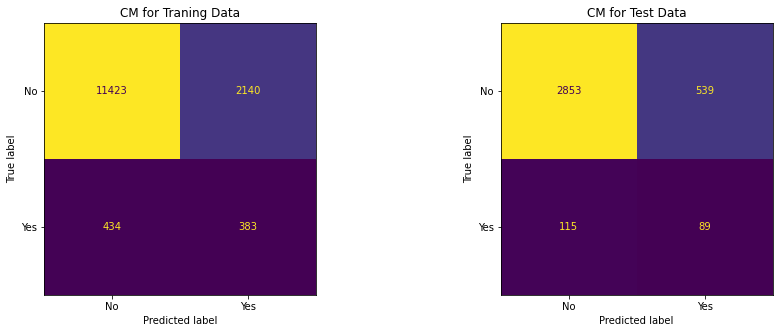

SMOTE RandomForestClassifier class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,0.981219,0.581656,0.730362,13563.000000
Yes,0.105047,0.815177,0.186111,817.000000
accuracy,0.594924,0.594924,0.594924,0.594924
macro avg,0.543133,0.698417,0.458237,14380.000000
weighted avg,0.931439,0.594924,0.699440,14380.000000
,precision,recall,f1-score,support
No,0.977306,0.584021,0.731131,3392.000000
Yes,0.100701,0.774510,0.178229,204.000000
accuracy,0.594828,0.594828,0.594828,0.594828
macro avg,0.539004,0.679266,0.454680,3596.000000


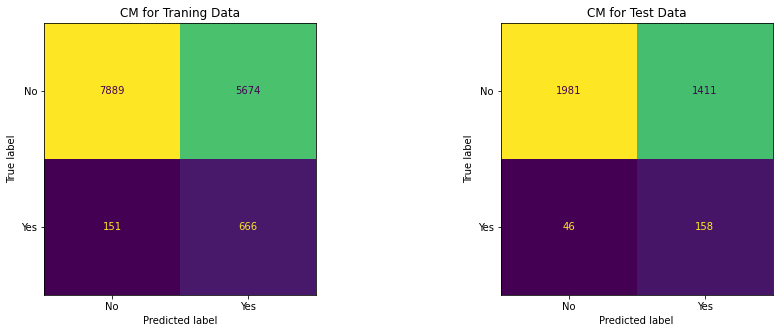

In [44]:
class_weight={'No': 0.3, 'Yes': 0.7}

classification_models = [
    make_custom_pipeline(StandardScaler(), SMOTE(), \
                         LogisticRegression(random_state=42, max_iter=10000)),
    make_custom_pipeline(StandardScaler(), SMOTE(), \
                         LogisticRegression(random_state=42, max_iter=10000, class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), SMOTE(), \
                         KNeighborsClassifier(n_neighbors=3)),
    make_custom_pipeline(StandardScaler(), SMOTE(), DecisionTreeClassifier()),
    make_custom_pipeline(StandardScaler(), SMOTE(), DecisionTreeClassifier(class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), SMOTE(), RandomForestClassifier(max_depth=5, random_state=0)),
    make_custom_pipeline(StandardScaler(), SMOTE(), RandomForestClassifier(max_depth=5, random_state=0,\
                                                                           class_weight=class_weight))
]

# fit
for pipe in classification_models:
    pipe.fit(X_train, y_train)

# predict
for pipe in classification_models:
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    handle_classification_results(y_train, y_train_pred, y_test, y_test_pred, pipe[1], pipe[2], model_comparisson)

RandomUnderSampler LogisticRegression class weight: None


,precision,recall,f1-score,support
No,0.976347,0.669542,0.794349,13563.000000
Yes,0.117543,0.730722,0.202510,817.000000
accuracy,0.673018,0.673018,0.673018,0.673018
macro avg,0.546945,0.700132,0.498430,14380.000000
weighted avg,0.927554,0.673018,0.760724,14380.000000
,precision,recall,f1-score,support
No,0.975786,0.677182,0.799513,3392.000000
Yes,0.118357,0.720588,0.203320,204.000000
accuracy,0.679644,0.679644,0.679644,0.679644
macro avg,0.547072,0.698885,0.501416,3596.000000


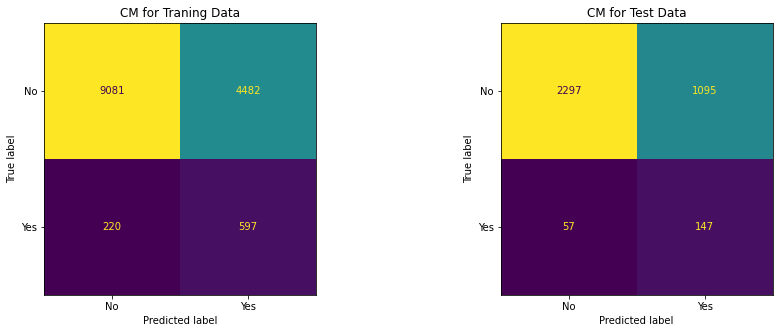

RandomUnderSampler LogisticRegression class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,0.987427,0.399543,0.568894,13563.00000
Yes,0.084121,0.915545,0.154084,817.00000
accuracy,0.428860,0.428860,0.428860,0.42886
macro avg,0.535774,0.657544,0.361489,14380.00000
weighted avg,0.936106,0.428860,0.545327,14380.00000
,precision,recall,f1-score,support
No,0.989450,0.387087,0.556474,3392.000000
Yes,0.083737,0.931373,0.153660,204.000000
accuracy,0.417964,0.417964,0.417964,0.417964
macro avg,0.536594,0.659230,0.355067,3596.000000


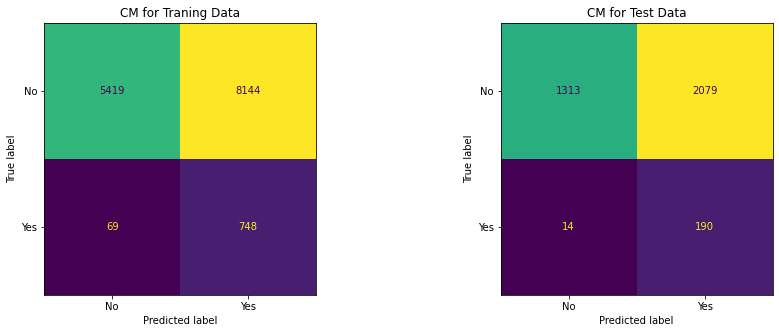

RandomUnderSampler KNeighborsClassifier class weight: None


,precision,recall,f1-score,support
No,0.981995,0.595149,0.741128,13563.000000
Yes,0.108604,0.818849,0.191773,817.000000
accuracy,0.607858,0.607858,0.607858,0.607858
macro avg,0.545300,0.706999,0.466451,14380.000000
weighted avg,0.932373,0.607858,0.709917,14380.000000
,precision,recall,f1-score,support
No,0.963353,0.565743,0.712853,3392.000000
Yes,0.081671,0.642157,0.144912,204.000000
accuracy,0.570078,0.570078,0.570078,0.570078
macro avg,0.522512,0.603950,0.428882,3596.000000


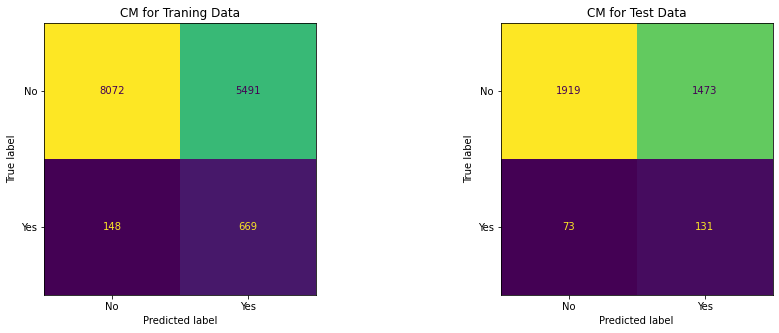

RandomUnderSampler DecisionTreeClassifier class weight: None


,precision,recall,f1-score,support
No,1.000000,0.617046,0.763177,13563.000000
Yes,0.135917,1.000000,0.239309,817.000000
accuracy,0.638804,0.638804,0.638804,0.638804
macro avg,0.567959,0.808523,0.501243,14380.000000
weighted avg,0.950907,0.638804,0.733414,14380.000000
,precision,recall,f1-score,support
No,0.961702,0.599646,0.738696,3392.000000
Yes,0.083052,0.602941,0.145994,204.000000
accuracy,0.599833,0.599833,0.599833,0.599833
macro avg,0.522377,0.601294,0.442345,3596.000000


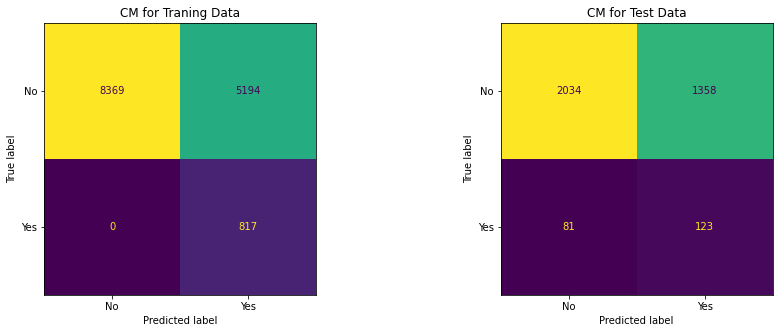

RandomUnderSampler DecisionTreeClassifier class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,1.000000,0.626115,0.770075,13563.000000
Yes,0.138757,1.000000,0.243699,817.000000
accuracy,0.647357,0.647357,0.647357,0.647357
macro avg,0.569378,0.813058,0.506887,14380.000000
weighted avg,0.951068,0.647357,0.740169,14380.000000
,precision,recall,f1-score,support
No,0.963265,0.626179,0.758978,3392.000000
Yes,0.088426,0.602941,0.154232,204.000000
accuracy,0.624861,0.624861,0.624861,0.624861
macro avg,0.525845,0.614560,0.456605,3596.000000


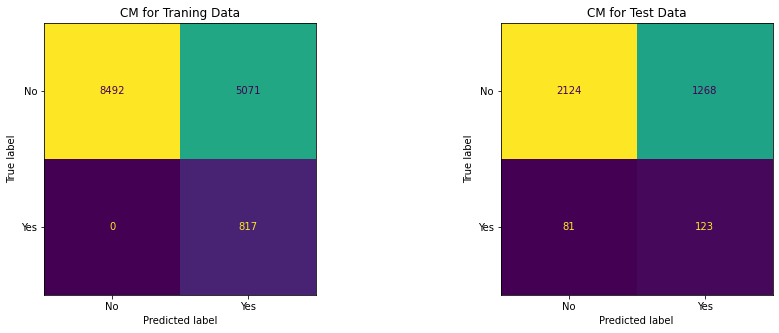

RandomUnderSampler RandomForestClassifier class weight: None


,precision,recall,f1-score,support
No,0.979990,0.693283,0.812074,13563.000000
Yes,0.130617,0.764994,0.223135,817.000000
accuracy,0.697357,0.697357,0.697357,0.697357
macro avg,0.555303,0.729139,0.517604,14380.000000
weighted avg,0.931732,0.697357,0.778613,14380.000000
,precision,recall,f1-score,support
No,0.969456,0.683078,0.801453,3392.000000
Yes,0.108624,0.642157,0.185816,204.000000
accuracy,0.680756,0.680756,0.680756,0.680756
macro avg,0.539040,0.662617,0.493634,3596.000000


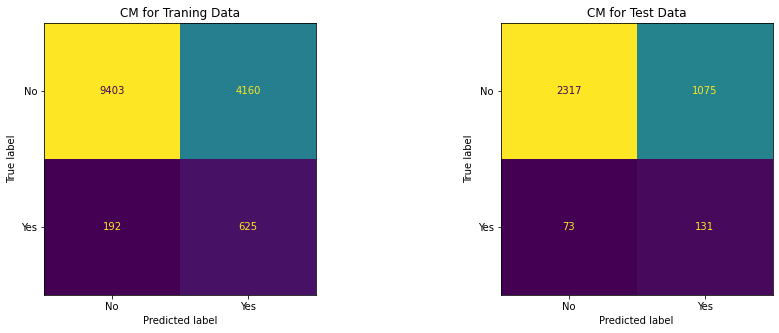

RandomUnderSampler RandomForestClassifier class weight: {'No': 0.3, 'Yes': 0.7}


,precision,recall,f1-score,support
No,0.996242,0.273612,0.429315,13563.000000
Yes,0.075364,0.982864,0.139993,817.000000
accuracy,0.313908,0.313908,0.313908,0.313908
macro avg,0.535803,0.628238,0.284654,14380.000000
weighted avg,0.943922,0.313908,0.412877,14380.000000
,precision,recall,f1-score,support
No,0.990991,0.259434,0.411215,3392.000000
Yes,0.072378,0.960784,0.134615,204.000000
accuracy,0.299221,0.299221,0.299221,0.299221
macro avg,0.531685,0.610109,0.272915,3596.000000


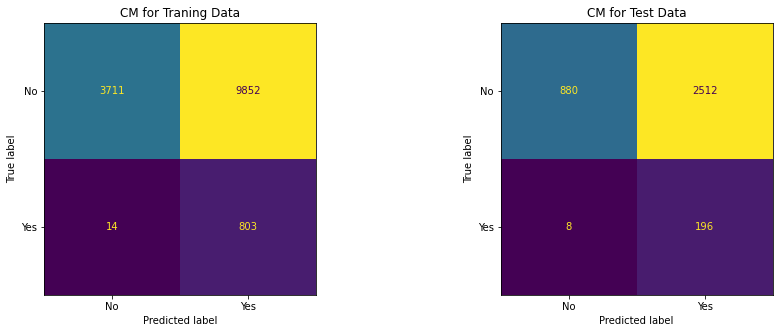

In [45]:
class_weight={'No': 0.3, 'Yes': 0.7}

classification_models_rus = [
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), \
                         LogisticRegression(random_state=42, max_iter=10000)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), \
                         LogisticRegression(random_state=42, max_iter=10000, class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), \
                         KNeighborsClassifier(n_neighbors=3)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), DecisionTreeClassifier()),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), DecisionTreeClassifier(class_weight=class_weight)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), RandomForestClassifier(max_depth=5, \
                                                                                        random_state=0)),
    make_custom_pipeline(StandardScaler(), RandomUnderSampler(), RandomForestClassifier(max_depth=5,\
                                                                                        random_state=0,\
                                                                           class_weight=class_weight))
]

for pipe in classification_models_rus:
    pipe.fit(X_train, y_train)

# predict
for pipe in classification_models_rus:
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    handle_classification_results(y_train, y_train_pred, y_test, y_test_pred, pipe[1], pipe[2], model_comparisson)

In [46]:
model_comparisson

,model,sampler,class_weight,f1_score,yes_f1,yes_precision,yes_recall,no_f1,no_precision,no_recall
0,LogisticRegression,SMOTE,None,0.696051,0.203933,0.119760,0.686275,0.812167,0.973630,0.696639
1,LogisticRegression,SMOTE,"{'No': 0.3, 'Yes': 0.7}",0.479700,0.165105,0.090820,0.906863,0.622097,0.987813,0.454009
2,KNeighborsClassifier,SMOTE,None,0.789766,0.135011,0.088060,0.289216,0.880342,0.950444,0.819870
3,DecisionTreeClassifier,SMOTE,None,0.881257,0.077754,0.069498,0.088235,0.936543,0.944261,0.928950
4,DecisionTreeClassifier,SMOTE,"{'No': 0.3, 'Yes': 0.7}",0.889878,0.108108,0.100000,0.117647,0.941316,0.946365,0.936321
5,RandomForestClassifier,SMOTE,None,0.818131,0.213942,0.141720,0.436275,0.897170,0.961253,0.841097
6,RandomForestClassifier,SMOTE,"{'No': 0.3, 'Yes': 0.7}",0.594828,0.178229,0.100701,0.774510,0.731131,0.977306,0.584021
7,LogisticRegression,RandomUnderSampler,None,0.679644,0.203320,0.118357,0.720588,0.799513,0.975786,0.677182
8,LogisticRegression,RandomUnderSampler,"{'No': 0.3, 'Yes': 0.7}",0.417964,0.153660,0.083737,0.931373,0.556474,0.989450,0.387087
9,KNeighborsClassifier,RandomUnderSampler,None,0.570078,0.144912,0.081671,0.642157,0.712853,0.963353,0.565743


In [48]:
model_comparisson.sort_values(by=['yes_recall'], ascending=False).head(4)

,model,sampler,class_weight,f1_score,yes_f1,yes_precision,yes_recall,no_f1,no_precision,no_recall
13,RandomForestClassifier,RandomUnderSampler,"{'No': 0.3, 'Yes': 0.7}",0.299221,0.134615,0.072378,0.960784,0.411215,0.990991,0.259434
8,LogisticRegression,RandomUnderSampler,"{'No': 0.3, 'Yes': 0.7}",0.417964,0.153660,0.083737,0.931373,0.556474,0.989450,0.387087
1,LogisticRegression,SMOTE,"{'No': 0.3, 'Yes': 0.7}",0.479700,0.165105,0.090820,0.906863,0.622097,0.987813,0.454009
6,RandomForestClassifier,SMOTE,"{'No': 0.3, 'Yes': 0.7}",0.594828,0.178229,0.100701,0.774510,0.731131,0.977306,0.584021
